<a href="https://colab.research.google.com/github/alibouch/TensorFlow_FSA_21-22/blob/main/Atelier_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atelier 9 : LES GANs


In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Introcuction

Comme le montre la figure suivante, un GAN est constitué de deux réseaux de neurones :

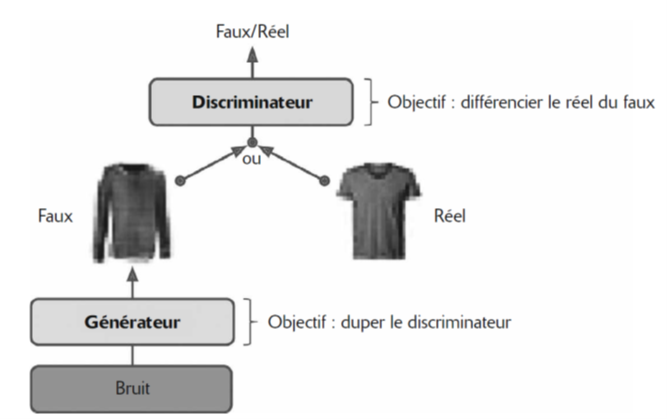

* **Un générateur** : <br />
Il prend en entrée une distribution aléatoire (typiquement gaussienne) et produit
en sortie des données (généralement une image). Vous pouvez considérer les
entrées aléatoires comme les représentations latentes (c’est-à-dire les codages) de l’image qui doit être générée. Vous le comprenez, le générateur joue un rôle comparable au décodeur dans un autoencodeur.<br />
* **Un discriminateur** :<br />
Il prend en entrée soit une image factice provenant du générateur, soit une
image réelle provenant du jeu d’entraînement, et doit deviner si cette image d’entrée est fausse ou réelle.

## Entraînement des GANs

Chaque itération d’entraînement comprend deux phases:<br />
• Au cours de la première phase, nous entraînons le discriminateur. Un lot
d’images réelles est échantillonné à partir du jeu entraînement, auquel est
ajouté un nombre égal d’images factices produites par le générateur. Les
étiquettes sont fixées à 0 pour les images factices et à 1 pour les images réelles.
Le discriminateur est entraîné sur ce lot étiqueté pendant une étape, en
utilisant une perte d’entropie croisée binaire. Il est important de noter que,
au cours de cette étape, la rétropropagation optimise uniquement les poids du
discriminateur.<br />
• Au cours de la seconde phase, nous entraînons le générateur. Nous l’utilisons
tout d’abord pour produire un autre lot d’images factices et, une fois encore, le
discriminateur doit dire si les images sont fausses ou réelles. Cette fois-ci, nous
n’ajoutons aucune image réelle au lot et toutes les étiquettes sont fixées à 1
(réelles). Autrement dit, nous voulons que le générateur produise des images
que le discriminateur considérera (à tort) réelles! Il est indispensable que les
poids du discriminateur soient figés au cours de cette étape, de sorte que la
rétropropagation affecte uniquement les poids du générateur.

Construisons un GAN simple pour Fashion MNIST.<br />**texte en gras**
Nous devons tout d’abord construire le générateur et le discriminateur. Le générateur est comparable au décodeur d’un autoencodeur, tandis que **le discriminateur**
est un classificateur binaire normal (il prend en entrée une image et se termine par
une couche Dense qui contient une seule unité et utilise la fonction d’activation
sigmoïde). Pour la seconde phase de chaque itération d’entraînement, nous avons
également besoin du modèle GAN complet constitué du générateur suivi du discriminateur:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

Nous devons à présent compiler ces modèles. Puisque le discriminateur est un classificateur binaire, nous pouvons naturellement utiliser la perte d’entropie croisée binaire.
Le générateur n’étant entraîné qu’au travers du modèle gan, il est donc inutile de le
compiler. Le modèle gan est également un classificateur binaire et peut donc utiliser la
perte d’entropie croisée binaire. Le discriminateur ne devant pas être entraîné au cours
de la seconde phase, nous le rendons non entraînable avant de compiler le modèle gan.

**1. Ajoutez les instruction nécessaires**

In [ ]:
                                                              # Compilation du discriminateur avec l'optimiseur RMSprop
                                                                #  Le discriminateur ne doit pas être entraîné 
                                                           # Compilation du GAN avec l'optimiseur RMSprop

Puisque la boucle d’entraînement est inhabituelle, nous ne pouvons pas utiliser
la méthode `fit()` normale. À la place, nous écrivons une boucle d’entraînement
personnalisée. Pour cela, nous devons tout d’abord créer un Dataset de façon à
parcourir les images:

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

**2. Nous sommes alors prêts à écrire la boucle d’entraînement, que nous plaçons dans
une fonction `train_gan()`:**

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for X_batch in dataset:
            # phase 1 
            noise = 
            generated_images = 
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = 
            discriminator.train_on_batch(            ,   )
            # phase 2 
            noise = 
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = 
            gan.train_on_batch(     ,     )
        plot_multiple_images(generated_images, 8)                    
        plt.show()                                                    

Comme nous l’avons décrit précédemment, vous pouvez constater les deux phases
de chaque itération:<br />
* Dans la phase  1, nous fournissons au générateur un bruit gaussien afin qu’il
produise des images factices et nous complétons ce lot d’images par autant
d’images réelles. Les cibles `y1` sont fixées à 0 pour les fausses images et à 1
pour les images réelles. Ensuite, nous entraînons le discriminateur sur ce lot.
Notez que nous fixons à `True` l’attribut `trainable` du discriminateur. Cela
permet simplement d’éviter que Keras n’affiche un avertissement lorsqu’il
remarque que `trainable` vaut à présent `False` alors qu’il valait `True` à la
compilation du modèle (ou inversement).<br />
* Dans la phase 2, nous fournissons au GAN du bruit gaussien. Son générateur
commence à produire des images factices, puis le discriminateur tente de
deviner si des images sont fausses ou réelles. Puisque nous voulons que le
discriminateur pense que les images fausses sont réelles, nous fixons les cibles
`y2` à 1. Notez que l’attribut `trainable` est mis à `False`, de nouveau pour
éviter un avertissement.

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

En affichant les images générées, vous constatez qu’au bout de la première époque, elles commencent déjà à ressembler à des images Fashion MNIST (mais avec beaucoup de bruit). Malheureusement, les images ne vont jamais réellement s’améliorer et vous pourrez même trouver des époques où le GAN semble oublier ce qu’il a appris. En réalité, l’entraînement d’un GAN peut se révéler un véritable défi.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

## GAN convolutifs profonds

Au début, les GAN se fondaient sur des couches de convolution mais ne tentaient de générer que de petites images. Peu après, de nombreux
chercheurs ont essayé de construire des GAN fondés sur des réseaux convolutifs plus
profonds afin de produire des images de plus grande taille. Cela s’est révélé délicat
car l’entraînement était très instable. Cependant, fin 2015, `Alec Radford et al.` ont
fini par réussir, après avoir mené de nombreuses expériences avec diverses architectures et différents hyperparamètres. Ils ont nommé leur architecture **GAN convolutif profond** (**DCGAN**, **D**eep **C**onvolutional **GAN**). Voici leurs principales propositions
pour mettre en place des GAN convolutifs stables:
* Remplacer les couches de pooling par des convolutions à pas (dans le
discriminateur) et par des convolutions transposées (dans le générateur)
* Utiliser une normalisation par lots dans le générateur et dans le discriminateur,
excepté dans la couche de sortie du générateur et dans la couche d’entrée du
discriminateur.
* Retirer les couches cachées intégralement connectées pour les architectures
plus profondes.
* Dans le générateur, choisir l’activation ReLU pour toutes les couches excepté
la couche de sortie, qui doit opter pour la fonction tanh.
* Dans le discriminateur, choisir l’activation Leaky ReLU pour toutes les couches.

**3. complétez le code suivant sachant que** le générateur prend des codages de taille 100, les projette en 6272 dimensions (= 7 × 7 × 128), et reforme le résultat pour obtenir un tenseur 7×7×128. Celui-ci subit une normalisation par lots, puis est transmis à une couche de convolution transposée avec un noyau de taille 5 et un pas (stride) de 2. Elle le suréchantillonne de 7×7 à 14×14 et réduit sa profondeur de 128 à 64 et utilisera la fonction d’activation `selu`. Le résultat subit de nouveau une normalisation par lots, puis est transmis à une autre couche de convolution transposée avec un noyau de taille 5 et un pas de 2. Elle le suréchantillonne de 14×14 à 28×28 et réduit sa profondeur de 64 à 1. Cette couche utilisera la fonction d’activation tanh. 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
                                                               ,
                                       ,
                                       ,
                                                                                                     ,
                                            ,
                                                                                                      ,
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Puisque la dernière couche du discriminateur utilise la fonction d’activation `tanh`, les sorties sont dans la plage –1 à 1. C’est pourquoi, avant d’entraîner le GAN, nous devons mettre à l’échelle le jeu d’entraînement de sorte qu’il se trouve dans cette plage. Nous devons également en changer
la forme pour ajouter la dimension du canal:

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. 

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

## CycleGAN

Le **CycleGAN** est un modèle qui permet de générer à partir d’une image sa transformation dans un autre domaine. L’idée est ici d’accumuler deux datasets, un pour chaque domaine, mais sans correspondance. Par exemple, si nous désirons entraîner un modèle à convertir un paysage d’été en paysage d’hiver, nous accumulerons deux datasets contenant respectivement de nombreux paysages d’été et de nombreux paysages d’hiver, sans avoir de correspondance directe d’un paysage à l’autre. Et, par le biais d’une architecture particulière (cf partie pour data-scientists), dans certaines conditions, le modèle apprendra à générer correctement la transformation d’une donnée d’entrée nouvelle :

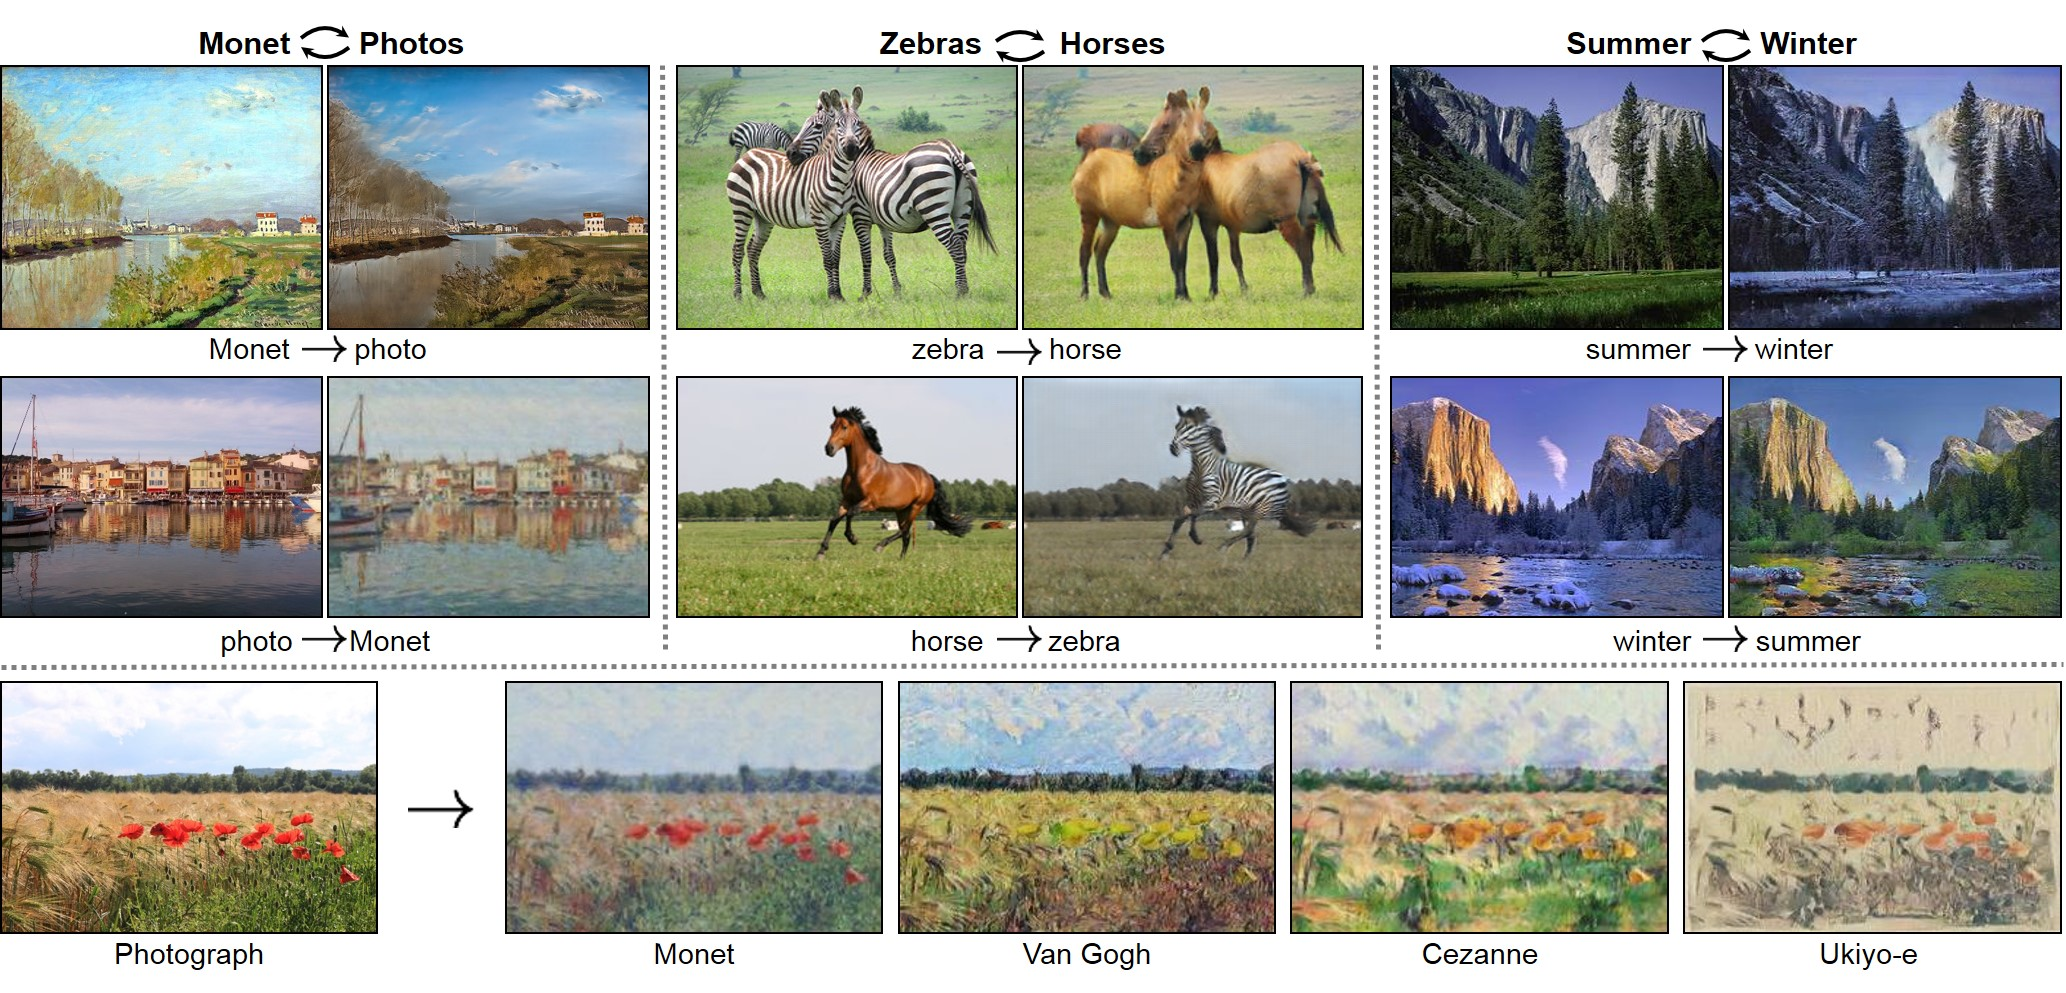

L'architecture du modèle est composée de deux générateurs : un générateur (**Generator-A**) pour générer des images pour le premier domaine (``Domaine-A``) et le deuxième générateur (**Generator-B**) pour générer des images pour le deuxième domaine (`Domaine-B`) .
* **Generator-A** -> `Domaine-A`
* **Generator-B** -> `Domaine-B`

Les générateurs effectuent une transformation d'image, ce qui signifie que le processus de génération d'image est conditionnel à une image d'entrée, en particulier une image de l'autre domaine. Le **Generator-A** prend une image du `Domaine-B` en entrée et le **Generator-B** prend une image du `Domaine-A` en entrée.

* `Domaine-B` -> **Generator-A** -> `Domaine-A`
* `Domaine-A` -> **Generator-B** -> `Domaine-B`

Chaque générateur a un discriminateur correspondant.

Le premier discriminateur (Discriminateur-A) prend des images réelles du `Domaine-A` et des images générées par **Generator-A** et prédit si elles sont réelles ou fausses. Le deuxième discriminateur (Discriminateur-B) prend des images réelles du `Domaine-B` et des images générées par **Generator-B** et prédit si elles sont réelles ou fausses.

* `Domaine-A` -> Discriminateur-A -> [Réel/Faux]
* `Domaine-B` -> **Generator-A** -> Discriminateur-A -> [Réel/Faux]
* `Domaine-B` -> Discriminateur-B -> [Réel/Faux]
* `Domaine-A` -> **Generator-B** -> Discriminateur-B -> [Réel/Faux]

Les discriminateurs et générateurs sont entraînés dans un processus contradictoire à somme nulle, comme les modèles GAN normaux.

Les générateurs apprennent à mieux tromper les discriminateurs et les discriminateurs apprennent à mieux détecter les fausses images. Ensemble, les modèles trouvent un équilibre au cours du processus d'apprentissage.

De plus, les générateurs sont régularisés non seulement pour créer de nouvelles images dans le domaine cible, mais plutôt pour créer des versions transformées des images d'entrée du domaine source. Ceci est réalisé en utilisant des images générées en entrée du modèle de générateur correspondant et en comparant l'image de sortie aux images d'origine.

Le passage d'une image à travers les deux générateurs s'appelle un cycle. Ensemble, chaque paire de générateurs est entraînée pour mieux reproduire l'image source d'origine, appelée cohérence de cycle.

* `Domaine-B` -> **Generator-A** -> `Domaine-A` -> **Generator-B** -> `Domaine-B`
* `Domaine-A` -> **Generator-B** -> `Domaine-B` -> **Generator-A** -> `Domaine-A`



In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
import os
import time
import tensorflow_datasets as tfds

`TensorFlow Datasets` comporte de nombreux ensembles de données appariés pour les CycleGANs, comme le cheval au zèbre, les pommes aux oranges, et ainsi de suite. Vous pouvez accéder au
liste complète ici : https://www.tensorflow.org/datasets/catalog/cycle_gan.
Nous utiliserons `summer2winter_yosemite`, qui contient des images
de Yosemite (vallée située aux USA) en été (Dataset A) et en hiver (Dataset B). Nous allons entraîner le CycleGAN pour transformer une image d'entrée d'été en hiver et vice versa. Commençons par charger les données  :

In [ ]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite',with_info=True, as_supervised=True)
train_A, train_B = dataset['trainA'], dataset['trainB']
test_A, test_B = dataset['testA'], dataset['testB']

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
AUTOTUNE = tf.data.experimental.AUTOTUNE

Les images doivent être normalisées avant d'entraîner le réseau :

In [ ]:
def normalize(input_image, label):  
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    return input_image

La fonction précédente, lorsqu'elle est appliquée aux images, les normalisera dans la plage [-1,1]. Appliquons cela à nos jeux de données d'entraînement et de test :

In [ ]:
train_A = train_A.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_B = train_B.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_A = test_A.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_B = test_B.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

jetons un coup d'oeil sur les images :

In [ ]:
inpA = next(iter(train_A))
inpB = next(iter(train_B))

In [ ]:
plt.subplot(121)
plt.title("Train Set A")
plt.imshow(inpA[0]*0.5 + 0.5)
plt.subplot(122)
plt.title("Train Set B")
plt.imshow(inpB[0]*0.5 + 0.5)

Pour construire le générateur et le discriminateur, nous aurons besoin de trois sous-modules : **la couche de sur-échantillonnage**, qui prendra une image et effectuera une convolution transposée ; **une couche de sous-échantillonnage**, qui effectuera la  convolution, et **une couche résiduelle** afin que d'avoir un modèle suffisamment profond. Ces couches sont définies dans les fonctions `downsample()`, `upsample()` et la classe `ResnetIdentityBlock` :

In [ ]:
def downsample(filters, size=3, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size=3, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__()
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()

    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
    self.bn2c = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)

    
block1 = ResnetIdentityBlock(3, [512, 512, 512])
block2 = ResnetIdentityBlock(3, [512, 512, 512])
block3 = ResnetIdentityBlock(3, [512, 512, 512])


resnet = [block1, block2, block3]
print(block1(tf.zeros([1, 16, 16, 512])).shape)
print([x.name for x in block1.trainable_variables])

Nous pouvons contruire le modèle

In [ ]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), 
        downsample(128, 4),
        downsample(256, 4), 
        downsample(512, 4) 
    ]

    up_stack = [
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') 


    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    for block in resnet:
        x = block(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        concat = tf.keras.layers.Concatenate()
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Visualisons le gégnérateur :

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, 'generator.png', show_shapes=True)

In [ ]:
generator.summary()

Le discriminateur reprend lui l’architecture des PatchGANs [https://arxiv.org/pdf/1611.07004.pdf], l’intérêt étant que l’architecture est indépendante de la dimension de l’image d’entrée.

In [ ]:
def Discriminator():
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    g_filter = 64
    
    down_stack = [
        downsample(g_filter),
        downsample(g_filter * 2),
        downsample(g_filter * 4),
        downsample(g_filter * 8),
    ]
    
    for down in down_stack:
        x = down(x)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same') # (bs, 30, 30, 1)
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
discriminator = Discriminator()
dis_output = discriminator(inpA, training=False)
print(dis_output.shape)

In [ ]:
tf.keras.utils.plot_model(discriminator, 'discriminator.png', show_shapes=True)

Nous construisons le CycleGAN:

In [ ]:
discriminator_A = Discriminator()
discriminator_B = Discriminator()

generator_AB = Generator()
generator_BA = Generator()

Ensuite, nous définissons la perte les optimiseurs :

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
@tf.function
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

Nous créons des emplacements pour les étiquettes des images réelles et des images fausses :

In [ ]:
valid = np.ones((BATCH_SIZE, 16, 16, 1)).astype('float32')
fake = np.zeros((BATCH_SIZE, 16, 16, 1)).astype('float32')

Nous définissons maintenant la fonction qui entraîne le générateur et le discriminateur dans un lot, une paire d'images à la fois :

In [ ]:
@tf.function
def train_batch(imgs_A, imgs_B):
    with tf.GradientTape() as g, tf.GradientTape() as d_tape:
        fake_B = generator_AB(imgs_A, training=True)
        fake_A = generator_BA(imgs_B, training=True)
        
        logits_real_A = discriminator_A(imgs_A, training=True)
        logits_fake_A = discriminator_A(fake_A, training=True)
        dA_loss = discriminator_loss(logits_real_A, logits_fake_A)
        
        logits_real_B = discriminator_B(imgs_B, training=True)
        logits_fake_B = discriminator_B(fake_B, training=True)
        dB_loss = discriminator_loss(logits_real_B, logits_fake_B)
        
        d_loss = (dA_loss + dB_loss) / 2
        # Translate images back to original domain
        reconstr_A = generator_BA(fake_B, training=True)
        reconstr_B = generator_AB(fake_A, training=True)
        
        id_A = generator_BA(imgs_A, training=True)
        id_B = generator_AB(imgs_B, training=True)


        gen_loss = tf.math.reduce_sum([
            1 * tf.math.reduce_mean(mean_squared_error(logits_fake_A, valid)),
            1 * tf.math.reduce_mean(mean_squared_error(logits_fake_B, valid)),
            10 * tf.math.reduce_mean(mean_squared_error(reconstr_A, imgs_A)),
            10 * tf.math.reduce_mean(mean_squared_error(reconstr_B, imgs_B)),
            0.1 * tf.math.reduce_mean(mean_squared_error(id_A, imgs_A)),
            0.1 * tf.math.reduce_mean(mean_squared_error(id_B, imgs_B)),
        ])
        
    gradients_of_d = d_tape.gradient(d_loss, discriminator_A.trainable_variables + discriminator_B.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_d, discriminator_A.trainable_variables + discriminator_B.trainable_variables))

    gradients_of_generator = g.gradient(gen_loss, generator_AB.trainable_variables + generator_BA.trainable_variables)
    optimizer.apply_gradients(zip(gradients_of_generator, generator_AB.trainable_variables + generator_BA.trainable_variables))
    
    return dA_loss, dB_loss, gen_loss

In [ ]:
checkpoint_dird_A = './training_checkpointsd_A'
checkpoint_prefixd_A = os.path.join(checkpoint_dird_A, "ckpt_{epoch}")

checkpoint_dird_B = './training_checkpointsd_B'
checkpoint_prefixd_B = os.path.join(checkpoint_dird_B, "ckpt_{epoch}")

checkpoint_dirg_AB = './training_checkpointsg_AB'
checkpoint_prefixg_AB = os.path.join(checkpoint_dirg_AB, "ckpt_{epoch}")

checkpoint_dirg_BA = './training_checkpointsg_BA'
checkpoint_prefixg_BA = os.path.join(checkpoint_dirg_BA, "ckpt_{epoch}")

Combinons le tout et entraînons le modèle :

In [ ]:
def train(trainA_, trainB_, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for batch_i, (imgs_A, imgs_B) in enumerate(zip(trainA_, trainB_)):
            dA_loss, dB_loss, g_loss = train_batch(imgs_A, imgs_B)
            
            if batch_i % 1000 == 0:
                test_imgA = next(iter(test_A))
                test_imgB = next(iter(test_B))
                print ('Time taken for epoch {} batch index {} is {} seconds\n'.format(epoch, batch_i, time.time()-start))
                print("discriminator A: ", dA_loss.numpy())
                print("discriminator B: ", dB_loss.numpy())
                print("generator: {}\n".format(g_loss))

                fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
                gen_outputA = generator_AB(test_imgA, training=False)
                gen_outputB = generator_BA(test_imgB, training=False)
                axs[0,0].imshow(test_imgA[0]*0.5 + 0.5)
                axs[0,0].set_title("Generator A Input")
                axs[0,1].imshow(gen_outputA[0]*0.5 + 0.5)
                axs[0,1].set_title("Generator A Output")
                axs[1,0].imshow(test_imgB[0]*0.5 + 0.5)
                axs[1,0].set_title("Generator B Input")
                axs[1,1].imshow(gen_outputB[0]*0.5 + 0.5)
                axs[1,1].set_title("Generator B Output")
                plt.show()

                discriminator_A.save_weights(checkpoint_prefixd_A.format(epoch=epoch))
                discriminator_B.save_weights(checkpoint_prefixd_B.format(epoch=epoch))
                generator_AB.save_weights(checkpoint_prefixg_AB.format(epoch=epoch))
                generator_BA.save_weights(checkpoint_prefixg_BA.format(epoch=epoch))

In [ ]:
train(train_A, train_B, EPOCHS)

In [ ]:
discriminator_A.save_weights('discriminator_A.h5')
discriminator_B.save_weights('discriminator_B.h5')
generator_AB.save_weights('generator_AB.h5')
generator_BA.save_weights('generator_BA.h5')

In [ ]:
discriminator_A.load_weights('./discriminator_A.h5')
discriminator_B.load_weights('./discriminator_B.h5')
generator_AB.load_weights('./generator_AB.h5')
generator_BA.load_weights('./generator_BA.h5')

In [ ]:
count = 10
for batch_i, (imgs_A, imgs_B) in enumerate(zip(test_A, test_B)):
    fake_B = generator_AB(imgs_A, training=False)
    fake_A = generator_BA(imgs_B, training=False)
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0,0].imshow(imgs_A[0]*0.5 + 0.5)
    axs[0,0].set_title("Generator A Input")
    axs[0,1].imshow(fake_B[0]*0.5 + 0.5)
    axs[0,1].set_title("Generator A Output")
    axs[1,0].imshow(imgs_B[0]*0.5 + 0.5)
    axs[1,0].set_title("Generator B Input")
    axs[1,1].imshow(fake_A[0]*0.5 + 0.5)
    axs[1,1].set_title("Generator B Output")
    plt.show()
    
    count -= 1
    if count <= 0:
        break